# Coding Discussion 05
### Ella Zhang

## Preparation

In [1]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

Below is a dataset that records the age, eduction level (of total years in school), income, race (caucasian or not), and past voting record (i.e. whether or not the respondent voted in the 2012 Presidential election).

In [2]:
# Read in the data
turnout = pd.read_csv("../turnout.csv")

# Drop id column and reorder columns
turnout = turnout[["vote","age","educate","income","white"]]

# Look at the head of the data
turnout.head()

,vote,age,educate,income,white
0,1,60,14.0,3.3458,1
1,0,51,10.0,1.8561,1
2,0,24,12.0,0.6304,1
3,1,38,8.0,3.4183,1
4,1,25,12.0,2.7852,1


## Train-Test Split
The sample is composed of 2000 individual respondents. Break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%).

In [3]:
# Set seed
np.random.seed(1234)

# Train-Test split
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 1600 
Test Data: 400


,vote,age,educate,income,white
0,1,78,16.0,1.3131,1
1,1,72,3.0,0.6765,0
2,1,64,10.0,1.3131,1
3,1,80,8.0,1.1839,1
4,1,19,14.0,2.9072,1


## Naive Bayesian Classifier

### Calculate Class Probabilities: $Pr(Class)$
(i.e. whether a respondent will vote in a presidential election or not)

In [4]:
N = train.shape[0]

# Subset the data by class
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vote_1 = vote1.shape[0]/N
pr_vote_0 = vote0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_vote_1}
Pr(vote = 0): {pr_vote_0}
""")


Pr(vote = 1): 0.7425
Pr(vote = 0): 0.2575



### Calculate the Conditional Probabilities: $Pr(data|class)$
### Binary Predictors
* $Pr(white=1|vote=1)$
* $Pr(white=0|vote=1)$
* $Pr(white=1|vote=0)$
* $Pr(white=0|vote=0)$

In [5]:
# Given vote == 1
white1_vote1 = vote1.query("white == 1").shape[0]/vote1.shape[0]
white0_vote1 = vote1.query("white == 0").shape[0]/vote1.shape[0]

# Given vote == 0
white1_vote0 = vote0.query("white == 1").shape[0]/vote0.shape[0]
white0_vote0 = vote0.query("white == 0").shape[0]/vote0.shape[0]

print(
f"""
Pr(white = 1 |vote = 1): {white1_vote1}
Pr(white = 0 |vote = 1): {white0_vote1}
Pr(white = 1 |vote = 0): {white1_vote0}
Pr(white = 0 |vote = 0): {white0_vote0}
""")


Pr(white = 1 |vote = 1): 0.8686868686868687
Pr(white = 0 |vote = 1): 0.13131313131313133
Pr(white = 1 |vote = 0): 0.7985436893203883
Pr(white = 0 |vote = 0): 0.20145631067961164



In [6]:
# Collect the conditional probabilities
cond_prob = \
{("white",1,1):white1_vote1,
 ("white",0,1):white0_vote1,
 ("white",1,0):white1_vote0,
 ("white",0,0):white0_vote0
}

# Print
pp.pprint(cond_prob)

{('white', 0, 0): 0.20145631067961164,
 ('white', 0, 1): 0.13131313131313133,
 ('white', 1, 0): 0.7985436893203883,
 ('white', 1, 1): 0.8686868686868687}


### Continuous Predictors
Calculate the conditional mean and standard deviation for each value of the outcome.

In [7]:
# Collect the mean and standard deviation of each conditional distribution
dist_locs = \
{("age",1):{'mean':vote1.age.mean(),'sd':vote1.age.std()},
 ("age",0):{'mean':vote0.age.mean(),'sd':vote0.age.std()},
 ("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()}
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853727},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.3043810919835317},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.2957141274443202},
 ('income', 0): {'mean': 2.738161893203883, 'sd': 2.242991372933763},
 ('income', 1): {'mean': 4.229461952861953, 'sd': 2.848208991067699}}


View what these different conditional distributions look like.

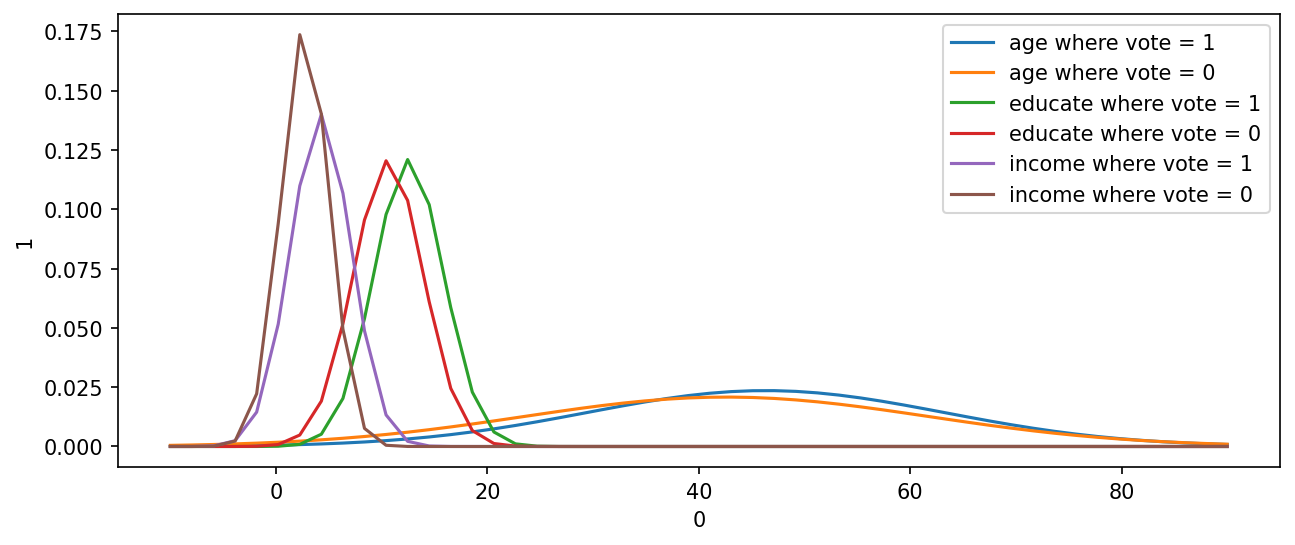

In [8]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-10,90)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where vote = {key[1]}")

Try predicting a single observation.

In [9]:
vote,age,educate,income,white = train.iloc[6,:]
print(vote,age,educate,income,white)

1.0 23.0 12.0 2.1319 1.0


In [10]:
# Prediction for the 1 class
a = st.norm(dist_locs[("age",1)]['mean'], dist_locs[("age",1)]['sd']).pdf(age)
b = st.norm(dist_locs[("educate",1)]['mean'], dist_locs[("educate",1)]['sd']).pdf(educate)
c = st.norm(dist_locs[("income",1)]['mean'], dist_locs[("income",1)]['sd']).pdf(income)
d = white1_vote1
e = pr_vote_1
pr_1 = a * b * c * d * e

# Prediction for the 0 class
a = st.norm(dist_locs[("age",0)]['mean'], dist_locs[("age",0)]['sd']).pdf(age)
b = st.norm(dist_locs[("educate",0)]['mean'], dist_locs[("educate",0)]['sd']).pdf(educate)
c = st.norm(dist_locs[("income",0)]['mean'], dist_locs[("income",0)]['sd']).pdf(income)
d = white1_vote0
e = pr_vote_0
pr_0 = a * b * c * d * e

print(
f'''
    Pr(vote == 1| X): {pr_1}
    Pr(vote == 0| X): {pr_0}
''')


    Pr(vote == 1| X): 7.495521325143518e-05
    Pr(vote == 0| X): 4.818756601730137e-05



0.0075% is greater than 0.0048%, so we predict that vote = 1.

Calculate the predictions for multiple continuous variables.

In [11]:
def predict(data,binary,cond_prob,dist_locs):
    """
    This function calculates the conditional probabilities into each class and returns both the probabilities and the most likely class.
    
    Args:
        data (dataframe): dataframe of the training data
        binary (list): list of the binary variable names
        cond_prob (dict): dictionary containing the conditional probabilities for binary predictors
        dist_locs (dict): dictionary containing the conditional mean and standard deviation of each conditional distribution
    
    Returns:
        dict: dictionary containing the predictions
    """
    
    # Create an empty list to store the predictions
    store_preds = []
    
    for i,row in data.iterrows():
        # Initialize the probabilities to 1
        pr_0 = 1; pr_1 = 1
        
        for j in range(1,len(row)):
            if row.index[j] in binary: # binary variable
                pr_0 *= cond_prob[row.index[j],row.values[j],0]
                pr_1 *= cond_prob[row.index[j],row.values[j],1]
            else: # continuous variable
                # Get the predictions using a Gaussan distribution
                pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                                dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                                dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        
        # Multiply by the class probabilities
        pr_0 *= pr_vote_0
        pr_1 *= pr_vote_1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
        
        # Append the predictions to the list
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
binary = ["white"]
preds_train = predict(train,binary,cond_prob,dist_locs)

In [12]:
# Predicted output
preds_train.head(10)

,pr_0,pr_1,pred
0,3.632617e-06,1.535617e-05,1
1,3.258162e-07,8.439931e-08,0
2,3.954328e-05,6.544042e-05,1
3,7.829549e-06,7.723286e-06,0
4,2.550202e-05,5.713713e-05,1
5,2.383934e-06,1.232408e-06,0
6,4.818757e-05,7.495521e-05,1
7,1.409436e-05,5.479169e-05,1
8,3.377400e-05,8.911569e-05,1
9,3.426620e-05,1.301632e-04,1


Examine the predictive accuracy of the training data.

In [13]:
accuracy_train = sum(train.vote == preds_train.pred)/train.shape[0]
accuracy_train

0.736875

Examine the predictive accuracy of the test data.

In [14]:
preds_test = predict(test,binary,cond_prob,dist_locs)
accuracy_test = sum(test.vote == preds_test.pred)/test.shape[0]
accuracy_test

0.715

The predictive accuracy of the training data is 73.7% and the predictive accuracy of the test data is 71.5%.

## `sklearn` Implementation

In [15]:
# Organize our data real quick so it plugs into the sklearn API easily 
train_y = train["vote"]
train_x = train[["age","educate","income","white"]]
test_y = test["vote"]
test_x = test[["age","educate","income","white"]]

In [16]:
from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

# Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.7125

Consider alternative performance metrics.

In [17]:
m.roc_auc_score(test_y,y_pred)

0.575595238095238

Generate a ROC curve plot. First, we need the model to return probabilities not predictions.

In [18]:
probs = gnb.predict_proba(test_x)
probs = pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.382004,0.617996
1,0.089185,0.910815
2,0.275975,0.724025
3,0.255162,0.744838
4,0.036055,0.963945
...,...,...
395,0.168330,0.831670
396,0.274707,0.725293
397,0.021379,0.978621
398,0.438499,0.561501


In [19]:
# Generate the False Positive Rate and True Positive Rate given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

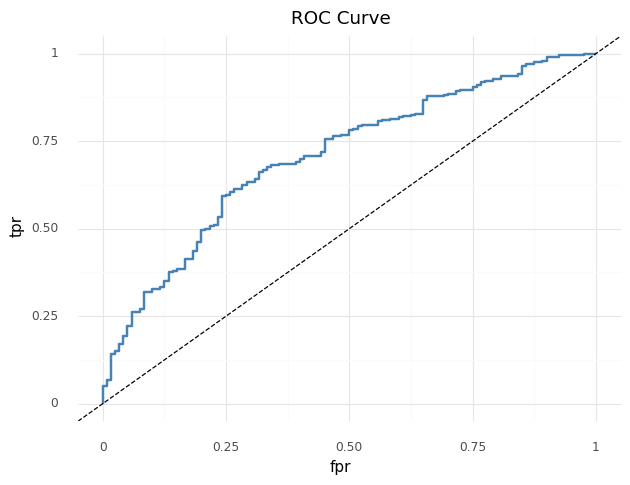

<ggplot: (273074411)>

In [20]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

## Summary
The accuray of our model is 0.7125, indicating that the model predicts the right class at about 71% chance. However, the AUC is only 0.575, which measures how true positive rate and false positive rate trade off. The AUC here suggests that our model predicts slightly better than flipping a coin. 